## Importing Dependencies:

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import mediapipe as mp
import time
import pyttsx3
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Importing Dataset:

In [2]:
train = pd.read_csv("train.csv")     
pq_file = "train_landmark_files\\16069\\10042041.parquet"
xyz = pd.read_parquet(pq_file)

## Processing Parquet File:

In [3]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

## Converting Mediapipe to Dataframe:

In [4]:
def create_frame_landmark_df(results, frame):
    xyz_skel = xyz[['type','landmark_index']].drop_duplicates().reset_index(drop=True).copy()   #Keep relevance to shape of training data

    face = pd.DataFrame()
    pose = pd.DataFrame()
    left_hand = pd.DataFrame()
    right_hand = pd.DataFrame()

    # Extract face landmarks
    if results.face_landmarks:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]	
            
    # Extract pose landmarks
    if results.pose_landmarks:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # Extract left hand landmarks
    if results.left_hand_landmarks:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # Extract right hand landmarks
    if results.right_hand_landmarks:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # Prepare DataFrames for each type of landmarks
    face = face.reset_index().rename(columns = {'index':'landmark_index'}).assign(type = 'face')
    pose = pose.reset_index().rename(columns = {'index':'landmark_index'}).assign(type = 'pose')
    left_hand = left_hand.reset_index().rename(columns = {'index':'landmark_index'}).assign(type = 'left_hand')
    right_hand = right_hand.reset_index().rename(columns = {'index':'landmark_index'}).assign(type = 'right_hand')

    # Concatenate all landmarks into a single DataFrame
    landmarks = pd.concat([face, pose, left_hand, right_hand]).reset_index(drop = True)

    # Merge with 'xyz_skel' DataFrame to map landmarks to their corresponding types and indices
    landmarks = xyz_skel.merge(landmarks, on = ['type','landmark_index'], how = 'left')
    
    # Assign the frame number to the landmarks
    landmarks = landmarks.assign(frame = frame)
    return landmarks     # Return the DataFrame containing extracted landmarks

## Loading Tensorflow Model:

In [5]:
interpreter = tf.lite.Interpreter("model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

## Testing using a training dataset parquet file:

In [7]:
def get_prediction(prediction_fn, pq_file):
    xyz_np = load_relevant_data_subset(pq_file)      # Conversion of parquet file to numpy array
    prediction = prediction_fn(inputs = xyz_np)      # Prediction from TFLite model
    pred = prediction['outputs'].argmax()            # Index of the predicted sign

    # Add ordinally Encoded Sign (assign number to each sign name)
    train['sign_ord'] = train['sign'].astype('category').cat.codes

    # Dictionaries to translate sign <-> ordinal encoded sign
    SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
    ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()
    sign = ORD2SIGN[pred]
    pred_conf = prediction['outputs'][pred]
    print(f'PREDICTED SIGN: {sign} [{pred}], CONFIDENCE:{ pred_conf : 0.4}')
    return sign

get_prediction(prediction_fn, pq_file)               # Prediction from TFLite model

PREDICTED SIGN: green [102], CONFIDENCE: 0.8284


'green'

## Testing using Live-Feed and Text to Speech:

In [9]:
# # Initialize MediaPipe Holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

# Create an empty list to store landmarks from each frame
all_landmarks = []

# Open a video capture object (using the default camera)
cap = cv2.VideoCapture(0)

# Initialize a text-to-speech engine
engine = pyttsx3.init()

# Using MediaPipe Holistic for pose detection and face mesh estimation
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    frame = 0                   # Frame counter
    start_time = time.time()    # Start time of the video
    text_timer = 0              # Timer for displaying text
    display_text = False        # Flag to display text
    text_to_display = ""        # Text to display on the frame
    while cap.isOpened():
        frame += 1
        success, image = cap.read()      # Read a frame from the video
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image)    # Process the frame with MediaPipe Holistic
        landmarks = create_frame_landmark_df(results, frame)   # Create a DataFrame with the extracted landmarks
        all_landmarks.append(landmarks)      # Append the landmarks to the list

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks on the frame
        mp.solutions.drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style())
        mp.solutions.drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style())

        # Logic for displaying and processing text on the image
        if display_text:
            if time.time() - text_timer >= 2:
                display_text = False

        if time.time() - start_time >= 3:
            if len(all_landmarks) > 0:
                landmarks_df = pd.concat(all_landmarks).reset_index(drop=True)
                landmarks_df.to_parquet("output.parquet")               # Save the landmarks to a parquet file
                pq_file = "output.parquet"
                sign_value = get_prediction(prediction_fn, pq_file)     # Prediction from TFLite model

                image = cv2.flip(image, 1)          # Flip the image horizontally
                image = cv2.putText(image, sign_value, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2,
                                    cv2.LINE_AA)    # Add predicted text to the image

                engine.say(sign_value)      # Text-to-speech
                engine.runAndWait() 

                text_to_display = sign_value
                display_text = True         # Display text
                text_timer = time.time()    # Reset timer

                start_time = time.time()    # Reset start time
                all_landmarks = []          # Reset landmarks list for the next cycle

        if display_text:
            image = cv2.putText(image, text_to_display, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2,
                                cv2.LINE_AA)        # Display text on the image

        cv2.imshow('MediaPipe Holistic', image)     # Display the annotated image
        if cv2.waitKey(1) & 0xFF == ord('q'):       # Exit the loop when 'q' is pressed
            break

cap.release()               # Release the video capture object 
cv2.destroyAllWindows()     # Close all OpenCV windows
  

PREDICTED SIGN: TV [0], CONFIDENCE: nan
PREDICTED SIGN: police [174], CONFIDENCE: 0.05167
PREDICTED SIGN: zebra [248], CONFIDENCE: 0.08561
PREDICTED SIGN: uncle [228], CONFIDENCE: 0.1388
PREDICTED SIGN: for [88], CONFIDENCE: 0.1102
PREDICTED SIGN: for [88], CONFIDENCE: 0.07607
PREDICTED SIGN: for [88], CONFIDENCE: 0.06576
PREDICTED SIGN: shoe [196], CONFIDENCE: 0.07165
PREDICTED SIGN: for [88], CONFIDENCE: 0.03974
PREDICTED SIGN: for [88], CONFIDENCE: 0.174
PREDICTED SIGN: hello [113], CONFIDENCE: 0.3937
PREDICTED SIGN: underwear [229], CONFIDENCE: 0.02908
PREDICTED SIGN: TV [0], CONFIDENCE: nan
PREDICTED SIGN: zebra [248], CONFIDENCE: 0.07956


# Replicate the Most Recent Displayed Sign by Animation

In [10]:

sign = pd.read_parquet(pq_file)    # Conversion of parquet file to pandas dataframe
sign.y = sign.y * -1               # Flip y axis

# Hand and Pose Coordinate Values

In [11]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

### Animation of the entire body utilizing all points available in each frame's data 

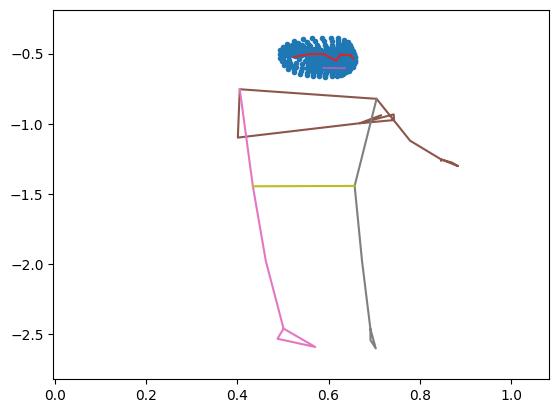

In [14]:
def animation_frame(f):
    # Extract data for frame 'f'
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    
    # Get coordinates for hands and pose points
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)

    # Clear the axis for the new frame
    ax.clear()

     # Plot face landmarks as dots
    ax.plot(face[:,0], face[:,1], '.')
    
    # Plot hand and pose landmarks
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    
    # Set the limits of the graph to stabilize the video
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
## Set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()        # Create figure and axis
l, = ax.plot([], [])

# Create the animation
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())        ## Display video in Jupyter Notebook

### Animation of the left hand only if visible   

c:\Users\Nisa\lib\site-packages\matplotlib\animation.py:1741: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


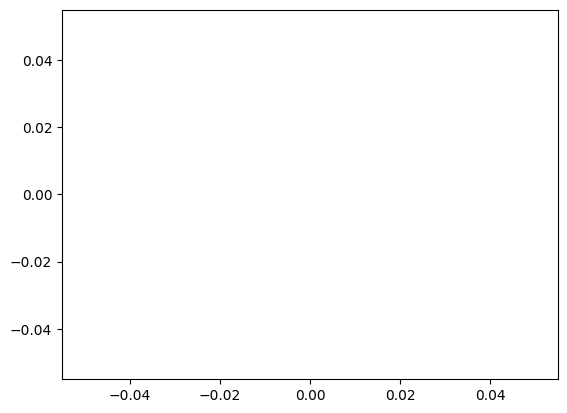

In [15]:
# Filter 'sign' DataFrame to keep rows with 'left_hand' type, dropping any missing values
sign = sign[sign.type=='left_hand'].dropna()

# Extract data for frame 'f'
def animation_frame(f):     
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    
    lx, ly = get_hand_points(left)      # Get coordinates for left hand points
    ax.clear()         
    
    # Plot hand landmarks
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## Set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()    # Create figure and axis
l, = ax.plot([], [])

# Create the animation
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())        ## Display video in Jupyter Notebook